In [1]:
import os
import pandas as pd
import metrics as mt
import os
import json
from rdkit import Chem
import numpy as np
import torch.nn as nn
from captum.attr import IntegratedGradients
from dgllife.utils import CanonicalAtomFeaturizer
from explainers_callers import (get_model_and_featurizer, get_ig_scores, get_subgX_scores,
                                get_molgraphx_scores, DEVICE)   
from Source.explainers import visualize
from tqdm import tqdm
from multiprocessing import Pool
from tqdm.contrib.concurrent import process_map
from torch import Tensor, nan, nan_to_num
from Source.explainers.subgraphX.utils import calculate_atom_scores_multiple_coalitions

MODEL_FOLDER = f"/home/cairne/WorkSpace/molgraphX_paper_scripts/GCNN_2D/Output/trained_model"

model, featurizer = get_model_and_featurizer(MODEL_FOLDER)

/home/cairne/WorkSpace/molgraphX_paper_scripts/GCNN_2D/Source/trainer.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = model_class(**torch.load(path_to_config))


In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import rdMolDraw2D
import numpy as np
from copy import deepcopy
def draw_molecule_colored_by_charge(mol, charges, img_size=(300, 300)):
    """
    Draw molecule with atoms colored by partial charges.
    
    Parameters:
    - mol: RDKit molecule object
    - charges: List of partial charges (one per atom, in atom index order)
    - img_size: Tuple (width, height) for output image
    - filename: Optional path to save the image (e.g., 'molecule.png')
    
    Returns:
    - PIL Image object if filename is None, else saves to file
    """
    if len(charges) != mol.GetNumAtoms():
        raise ValueError("Number of charges must match number of atoms in the molecule")

    # Calculate symmetric normalization factor
    max_abs_charge = max(abs(min(charges)), abs(max(charges)))
    if max_abs_charge < 1e-8:  # Avoid division by zero
        max_abs_charge = 1.0
    
    # Create atom color mapping
    atom_colors = {}
    for idx, atom in enumerate(mol.GetAtoms()):
        charge = charges[idx]
        norm_charge = charge / max_abs_charge  # Normalized to [-1, 1]
        
        if norm_charge > 0:
            # Positive: Red gradient (white -> red)
            red = 1.0
            green = blue = max(0.0, 1.0 - norm_charge)  # Desaturate toward white at zero
        else:
            # Negative: Blue gradient (white -> blue)
            blue = 1.0
            red = green = max(0.0, 1.0 + norm_charge)  # Desaturate toward white at zero
        
        atom_colors[idx] = (red, green, blue)
    
    # Draw molecule
    drawer = rdMolDraw2D.MolDraw2DCairo(img_size[0], img_size[1])
    opts = drawer.drawOptions()
    opts.useBWAtomPalette()  # Prevents default element-based coloring
    
    # Draw with custom atom colors
    rdMolDraw2D.PrepareAndDrawMolecule(
        drawer,
        mol,
        highlightAtoms=range(mol.GetNumAtoms()),
        highlightAtomColors=atom_colors
    )
    
    drawer.FinishDrawing()
    
    # Return or save image
    img = drawer.GetDrawingText()
    from PIL import Image
    import io
    return Image.open(io.BytesIO(img))

def rotate_molecule(mol, angle_degrees):
    """
    Rotate molecule coordinates in 2D plane around its centroid.
    
    Parameters:
    - mol: RDKit molecule object (will be copied to avoid modifying original)
    - angle_degrees: Rotation angle in degrees (positive = counter-clockwise)
    
    Returns:
    - New molecule object with rotated coordinates
    """
    # Create a copy to avoid modifying original molecule
    mol_copy = deepcopy(mol)
    
    # Ensure 2D coordinates exist
    if not mol_copy.GetNumConformers():
        AllChem.Compute2DCoords(mol_copy)
    
    conf = mol_copy.GetConformer()
    coords = np.array([list(conf.GetAtomPosition(i))[:2] for i in range(mol_copy.GetNumAtoms())])
    
    # Calculate centroid
    centroid = coords.mean(axis=0)
    
    # Translate to origin
    centered_coords = coords - centroid
    
    # Create rotation matrix
    angle_rad = np.deg2rad(angle_degrees)
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad), np.cos(angle_rad)]
    ])
    
    # Apply rotation
    rotated_coords = centered_coords @ rotation_matrix.T
    
    # Translate back to original position
    final_coords = rotated_coords + centroid
    
    # Update coordinates in conformer
    for i, (x, y) in enumerate(final_coords):
        conf.SetAtomPosition(i, (x, y, 0.0))
    
    return mol_copy

[-0.0020777609450206716, -0.0012310575769339741, -0.003074006540801702, -0.003078357026210067, -0.0030797114250532944, -0.003078357026210067, -0.003074006540801702, -0.0012310575769339741, -0.0020777609450206716]


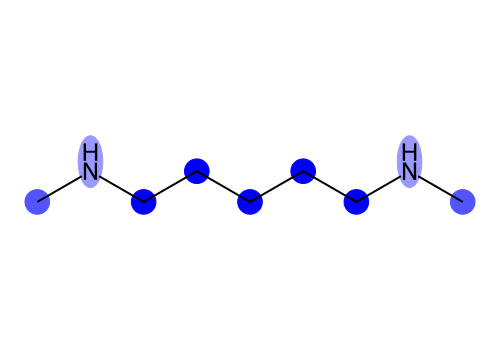

In [4]:
from rdkit.Chem.Draw import MolDraw2DCairo
from rdkit.Chem import rdDepictor,rdMolTransforms
drawer = MolDraw2DCairo(300, 300)
sm = "CNCCCCCNC"
m = Chem.MolFromSmiles(sm)
# m = rotate_molecule(m, 180)
scores = get_ig_scores(m, model, featurizer)
print(scores)
img = draw_molecule_colored_by_charge(m, scores, img_size=(500, 350))
img

In [6]:
from pdf2docx import Converter
import glob
import os
from pdf2docx import Converter
import glob
from docx import Document
import os
# List your PDF files in order



from pdf2docx import Converter
from docx import Document

def convert_and_merge_pdfs(pdf_files, output_docx):
    temp_docx_files = []
    
    # Convert each PDF to individual DOCX
    for i, pdf_file in enumerate(pdf_files):
        temp_file = f"temp_{i}.docx"
        print(f"Converting {pdf_file} to {temp_file}...")
        
        cv = Converter(pdf_file)
        cv.convert(temp_file)
        cv.close()
        temp_docx_files.append(temp_file)
    
    # Merge all DOCX files
    master_doc = Document(temp_docx_files[0])
    
    for temp_file in temp_docx_files[1:]:
        # Add page break
        master_doc.add_page_break()
        
        # Append the next document
        temp_doc = Document(temp_file)
        for element in temp_doc.element.body:
            master_doc.element.body.append(element)
    
    # Save final document
    master_doc.save(output_docx)
    
    # Clean up temporary files
    for temp_file in temp_docx_files:
        os.remove(temp_file)
    
    print(f"Successfully merged {len(pdf_files)} PDFs into {output_docx}")

# Usage
fold = "/home/cairne/WorkSpace/molgraphX_paper_scripts/GCNN_2D/Output/output-1"
pdf_files = [os.path.join(fold, i) for i in os.listdir(fold)]
merge_pdfs_with_breaks(pdf_files, 'merged_output.docx')

[INFO] Start to convert /home/cairne/WorkSpace/molgraphX_paper_scripts/GCNN_2D/Output/output-1/page1.pdf
[INFO] [1/4] Opening document...
[INFO] [2/4] Analyzing document...
[WARNING] Words count: 0. It might be a scanned pdf, which is not supported yet.
[INFO] [3/4] Parsing pages...
[INFO] (1/1) Page 1
[INFO] [4/4] Creating pages...
[INFO] (1/1) Page 1
[INFO] Terminated in 0.05s.
[INFO] Start to convert /home/cairne/WorkSpace/molgraphX_paper_scripts/GCNN_2D/Output/output-1/page2.pdf
[INFO] [1/4] Opening document...
[INFO] [2/4] Analyzing document...
[WARNING] Words count: 0. It might be a scanned pdf, which is not supported yet.
[INFO] [3/4] Parsing pages...
[INFO] (1/1) Page 1
[INFO] [4/4] Creating pages...
[INFO] (1/1) Page 1
[INFO] Terminated in 0.04s.
[INFO] Start to convert /home/cairne/WorkSpace/molgraphX_paper_scripts/GCNN_2D/Output/output-1/page3.pdf
[INFO] [1/4] Opening document...
[INFO] [2/4] Analyzing document...
[WARNING] Words count: 0. It might be a scanned pdf, which is

Successfully merged 93 PDFs into merged_output.docx


In [ ]:
from docxcompose.composer import Composer
from docx import Document

def merge_docs(output_path, *input_paths):
    base_doc = Document(input_paths[0])
    composer = Composer(base_doc)

    for file_path in input_paths[1:]:
        doc = Document(file_path)
        composer.append(doc)
        doc.add_paragraph()

    composer.save(output_path)
fold = "/home/cairne/Downloads/pdf24_convertPdfTo"
pdf_files = [os.path.join(fold, i) for i in os.listdir(fold)]
merge_docs("final_report.docx", *pdf_files)